* Read Data
* Make Dataset of `imagepath` and `labels`
* Convert images into tensors
* Test-Train-Split
* Train a DenseNet121 model
* Test the model
* Get Metrics
* ROC Curve

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.layers import Dense, Flatten, Input, Lambda
from tensorflow import keras

## **Read Data**

In [2]:
data=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MIAS-Classification/Info.txt",sep=" ")
data

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,Unnamed: 7
0,mdb001,G,CIRC,B,535.0,425.0,197.0,NaN
1,mdb002,G,CIRC,B,522.0,280.0,69.0,NaN
2,mdb003,D,NORM,NaN,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0,NaN
...,...,...,...,...,...,...,...,...
325,mdb318,D,NORM,NaN,NaN,NaN,NaN,NaN
326,mdb319,D,NORM,NaN,NaN,NaN,NaN,NaN
327,mdb320,D,NORM,NaN,NaN,NaN,NaN,NaN
328,mdb321,D,NORM,NaN,NaN,NaN,NaN,NaN


In [3]:
data.SEVERITY.fillna("H", inplace=True)
data.SEVERITY = data.SEVERITY.map({'H':0, 'B':1, 'M':2})

In [4]:
data.SEVERITY.unique()

array([1, 0, 2])

In [5]:
_ = [ 'BG', 'CLASS', 'X', 'Y', 'RADIUS', 'Unnamed: 7']
data = data.drop(_, axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   REFNUM    330 non-null    object
 1   SEVERITY  330 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.3+ KB


In [6]:
data = data.drop([5], axis=0)
data.reset_index(inplace = True)
data = data.drop("index",axis=1)
data

,REFNUM,SEVERITY
0,mdb001,1
1,mdb002,1
2,mdb003,0
3,mdb004,0
4,mdb005,1
...,...,...
324,mdb318,0
325,mdb319,0
326,mdb320,0
327,mdb321,0


## **Make Dataset of ```imagepath``` and ```labels```**






In [7]:
ohe = OneHotEncoder()
img_labels = ohe.fit_transform(data.SEVERITY.values.reshape(-1, 1)).toarray()

In [8]:
path = "/content/drive/MyDrive/Colab Notebooks/MIAS-Classification/all-mias/"
img_paths = []
# img_labels = []

for i in range(len(data)):
  abs_path = path + data.REFNUM[i] + '.pgm'
  img_paths.append(abs_path)
  # img_labels.append(data.SEVERITY[i])

In [9]:
img_paths[0], img_labels[0]

('/content/drive/MyDrive/Colab Notebooks/MIAS-Classification/all-mias/mdb001.pgm',
 array([0., 1., 0.]))

In [10]:
image_numeric = []
for img in img_paths:
  image = cv2.imread(img)
  image = cv2.resize(image, (224,224)) # put `/255` to normalize the colour scores
  image_numeric.append(image)

In [11]:
image_numeric = np.array(image_numeric)/255.0
img_labels = np.array(img_labels)

In [12]:
image_numeric[0].shape

(224, 224, 3)

In [13]:
img_labels.shape

(329, 3)

## **Train-Test-Split**

In [14]:
x_train, x_test, y_train, y_test = train_test_split(image_numeric, img_labels, test_size = 0.3, random_state = 42)

In [15]:
# y_train=y_train.reshape(-1,1)

In [16]:
print(x_train.shape) #, y_train.shape, x_test.shape, y_test.shape
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(230, 224, 224, 3)
(230, 3)
(99, 224, 224, 3)
(99, 3)


In [17]:
# x_train = x_train[..., np.newaxis]

In [18]:
x_train.shape

(230, 224, 224, 3)

## **Train a DenseNet121 Model**

In [19]:
%%time
base_model = DenseNet121(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False
)

base_model.trainable = False

# Create inputs with correct shape
inputs = Input(shape = (224,224,3))

x = base_model(inputs, training=False)
# Add pooling layer or flatten layer
x = keras.layers.GlobalAveragePooling2D()(x)


# Add final dense layer
outputs = Dense(3, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs, outputs)

model.compile(loss = keras.losses.CategoricalCrossentropy() , metrics = ['accuracy']) # compiles the model with the given parameters

model.summary() # prints a summary of the model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 3,075
Non-trainable params: 7,037,504
_________________________________________________________________
CPU times: user 5.03 s, sys: 391 ms, total: 5.43 s
Wall time: 5.35 s


In [20]:
%%time
EPOCH = 25
d_model = model.fit(x_train, y_train, epochs = EPOCH, validation_data = (x_test, y_test) )

Epoch 1/25
8/8 [==============================] - 18s 958ms/step - loss: 0.9970 - accuracy: 0.5739 - val_loss: 1.1175 - val_accuracy: 0.4545
Epoch 2/25
8/8 [==============================] - 2s 296ms/step - loss: 0.9317 - accuracy: 0.6130 - val_loss: 1.2319 - val_accuracy: 0.2424
Epoch 3/25
8/8 [==============================] - 2s 295ms/step - loss: 0.9437 - accuracy: 0.5696 - val_loss: 1.1824 - val_accuracy: 0.5758
Epoch 4/25
8/8 [==============================] - 2s 295ms/step - loss: 0.8830 - accuracy: 0.6348 - val_loss: 1.0195 - val_accuracy: 0.5556
Epoch 5/25
8/8 [==============================] - 3s 382ms/step - loss: 0.8630 - accuracy: 0.6478 - val_loss: 1.0264 - val_accuracy: 0.5657
Epoch 6/25
8/8 [==============================] - 2s 295ms/step - loss: 0.8518 - accuracy: 0.6435 - val_loss: 1.2943 - val_accuracy: 0.5758
Epoch 7/25
8/8 [==============================] - 2s 296ms/step - loss: 0.8605 - accuracy: 0.6391 - val_loss: 1.1609 - val_accuracy: 0.5758
Epoch 8/25
8/8 [===

## **Confusion Matrix and Classification Report**

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

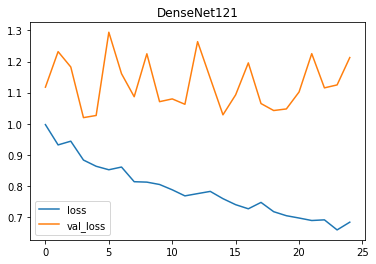

In [22]:
# loss
fig, ax = plt.subplots()
ax.plot(d_model.history['loss'], label='loss')
ax.plot(d_model.history['val_loss'], label='val_loss')
ax.legend()
plt.title('DenseNet121')
plt.show()
fig.savefig('/content/drive/MyDrive/Colab Notebooks/MIAS-Classification/DenseNet121Loss.png')

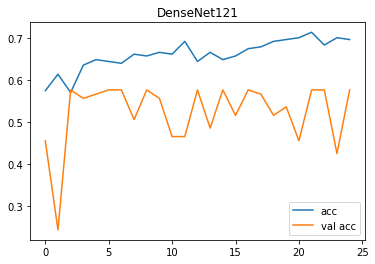

In [23]:
# accuracies
fig, ax = plt.subplots()
ax.plot(d_model.history['accuracy'], label='acc')
ax.plot(d_model.history['val_accuracy'], label='val acc')
ax.legend()
plt.title('DenseNet121')
plt.show()
fig.savefig('/content/drive/MyDrive/Colab Notebooks/MIAS-Classification/DenseNet121Accuracy.png')

In [24]:
model.save("/content/drive/MyDrive/Colab Notebooks/MIAS-Classification/Densenet121.h5")

In [25]:
y_preds =  model.predict(x_test)
y_preds

array([[0.7881713 , 0.13571832, 0.07611039],
       [0.8774001 , 0.1000087 , 0.02259125],
       [0.8353277 , 0.07144071, 0.09323156],
       [0.8229321 , 0.12284651, 0.05422137],
       [0.9697259 , 0.02352021, 0.00675394],
       [0.5171712 , 0.3172215 , 0.1656073 ],
       [0.8367496 , 0.06519335, 0.09805708],
       [0.8465566 , 0.09829152, 0.05515191],
       [0.84172195, 0.05848015, 0.09979788],
       [0.93183595, 0.03553533, 0.03262874],
       [0.7046127 , 0.19418572, 0.10120173],
       [0.7052017 , 0.26415452, 0.0306438 ],
       [0.73744684, 0.12934999, 0.13320327],
       [0.57151705, 0.08982477, 0.33865818],
       [0.6373987 , 0.07955952, 0.28304183],
       [0.73624367, 0.20584862, 0.05790778],
       [0.8708296 , 0.0853143 , 0.0438561 ],
       [0.69416744, 0.17229618, 0.13353638],
       [0.8351295 , 0.13262057, 0.03224995],
       [0.6849873 , 0.10696968, 0.20804308],
       [0.92521906, 0.05212051, 0.02266035],
       [0.7104058 , 0.23882774, 0.0507664 ],
       [0.

In [26]:
y_preds_ind = np.argmax(y_preds,axis=1)
y_preds_ind

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
qwe=np.argmax(y_test, axis=1)

In [28]:
confusion_matrix(qwe,y_preds_ind)

array([[57,  0,  0],
       [20,  0,  0],
       [22,  0,  0]])

In [29]:
print(classification_report(qwe,y_preds_ind))

              precision    recall  f1-score   support

           0       0.58      1.00      0.73        57
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        22

    accuracy                           0.58        99
   macro avg       0.19      0.33      0.24        99
weighted avg       0.33      0.58      0.42        99



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
model.evaluate(x_test,y_test)

4/4 [==============================] - 1s 157ms/step - loss: 1.2128 - accuracy: 0.5758


[1.2128278017044067, 0.5757575631141663]

## **ROC Curve**

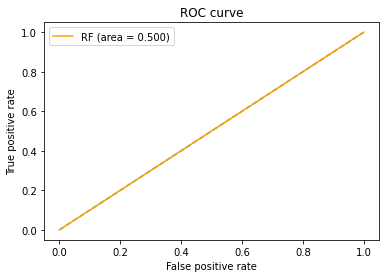

In [31]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(qwe, y_preds_ind, pos_label=2)

auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1],"--")

plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc), color='orange')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### **Visualization**

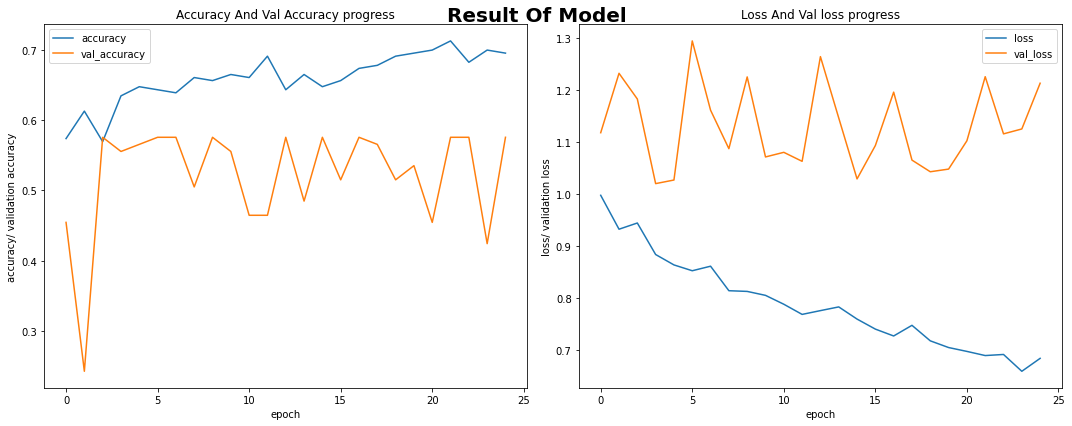

In [32]:
def Visualize_Result(acc,val_acc,loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(nrows = 1,
                                   ncols = 2,
                                   figsize = (15,6))

    plot1 = ax1.plot(range(0, len(acc)),
                     acc,
                     label = 'accuracy')

    plot2 = ax1.plot(range(0, len(val_acc)),
                     val_acc,
                     label = 'val_accuracy')

    ax1.set(title = 'Accuracy And Val Accuracy progress',
            xlabel = 'epoch',
            ylabel = 'accuracy/ validation accuracy')

    ax1.legend()

    plot3 = ax2.plot(range(0, len(loss)),
                     loss,
                     label = 'loss')
    
    plot4 = ax2.plot(range(0, len(val_loss)),
                     val_loss,
                     label = 'val_loss')
    
    ax2.set(title = 'Loss And Val loss progress',
            xlabel = 'epoch',
            ylabel = 'loss/ validation loss')

    ax2.legend()

    fig.suptitle('Result Of Model', fontsize = 20, fontweight = 'bold')
    fig.savefig('/content/drive/MyDrive/Colab Notebooks/MIAS-Classification/Accuracy_Loss_figure.png')
    plt.tight_layout()
    plt.show()

visualize_result = Visualize_Result(d_model.history['accuracy'],d_model.history['val_accuracy'], d_model.history['loss'], d_model.history['val_loss'])


## **Cross-Validation**

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [34]:
#set early stopping criteria
pat = 5 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/MIAS-Classification/Models/h_mias.h5', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(x_train, x_test, y_train, y_test, EPOCHS=20, BATCH_SIZE=32,model=model):
    results = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
                        verbose=1, validation_split=0.3)  
    print("Val Score: ", model.evaluate(x_test,y_test))
    return results

In [35]:
n_folds=10
epochs=20
batch_size=32

#save the model history after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    x_train, x_test, y_train, y_test = train_test_split(image_numeric, img_labels, test_size = 0.3, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(x_train, x_test, y_train, y_test, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/20
6/6 [==============================] - 4s 711ms/step - loss: 0.7698 - accuracy: 0.6770 - val_loss: 1.2089 - val_accuracy: 0.5652

Epoch 00001: val_loss improved from inf to 1.20888, saving model to /content/drive/MyDrive/Colab Notebooks/MIAS-Classification/Models/h_mias.h5
Epoch 2/20
6/6 [==============================] - 2s 310ms/step - loss: 0.7906 - accuracy: 0.7019 - val_loss: 1.0166 - val_accuracy: 0.5507

Epoch 00002: val_loss improved from 1.20888 to 1.01657, saving model to /content/drive/MyDrive/Colab Notebooks/MIAS-Classification/Models/h_mias.h5
Epoch 3/20
6/6 [==============================] - 2s 279ms/step - loss: 0.7404 - accuracy: 0.7205 - val_loss: 1.0411 - val_accuracy: 0.5217

Epoch 00003: val_loss did not improve from 1.01657
Epoch 4/20
6/6 [==============================] - 2s 279ms/step - loss: 0.8085 - accuracy: 0.6832 - val_loss: 0.9270 - val_accuracy: 0.5507

Epoch 00004: val_loss improved from 1.01657 to 0.92703, saving model to 

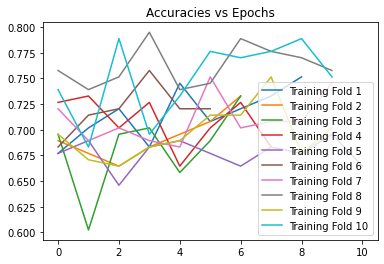

In [36]:
plt.title('Accuracies vs Epochs')
for i in range(len(model_history)):
  plt.plot(model_history[i].history['accuracy'], label=f"Training Fold {i+1}")

plt.legend()
plt.show()

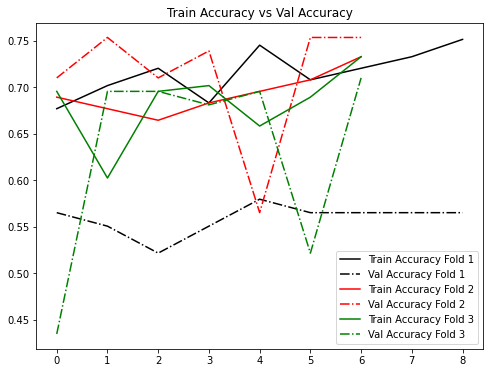

In [37]:
plt.figure(figsize=(8,6))
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

In [38]:
# plt.figure(figsize=(15,10))
# plt.title('Train Accuracy vs Val Accuracy')
# for i in range(len(model_history)):
#   plt.plot(model_history[i].history['accuracy'], label=f"Trai Accuracy Fold {i+1}")
#   plt.plot(model_history[i].history['val_accuracy'], label=f'Val Accuracy Fold {i+1}', linestyle = "dashdot")

# plt.legend()
# plt.show()

In [39]:
#Load the model that was saved by ModelCheckpoint
from tensorflow import keras

model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/MIAS-Classification/Models/h_mias.h5')

model.evaluate(x_test,y_test)

4/4 [==============================] - 3s 171ms/step - loss: 0.6137 - accuracy: 0.7475


[0.6137328743934631, 0.747474730014801]

In [40]:
y_preds =  model.predict(x_test)
y_preds

array([[0.9717381 , 0.00952405, 0.01873781],
       [0.61315084, 0.31013206, 0.07671708],
       [0.7804417 , 0.18726452, 0.03229377],
       [0.7263663 , 0.19391532, 0.07971837],
       [0.8484941 , 0.12123728, 0.03026869],
       [0.6348121 , 0.19642158, 0.16876629],
       [0.69299436, 0.28303993, 0.0239657 ],
       [0.9126077 , 0.06425921, 0.02313303],
       [0.713102  , 0.12457737, 0.16232057],
       [0.8568158 , 0.09953926, 0.04364493],
       [0.83156925, 0.08656546, 0.08186528],
       [0.74202585, 0.16412963, 0.0938445 ],
       [0.9594923 , 0.01882776, 0.02168   ],
       [0.77550125, 0.07561079, 0.14888798],
       [0.9166032 , 0.04351611, 0.03988064],
       [0.88886553, 0.09024502, 0.02088952],
       [0.8539085 , 0.10748003, 0.0386115 ],
       [0.36078176, 0.5376632 , 0.10155496],
       [0.6719837 , 0.24087505, 0.08714122],
       [0.9279588 , 0.03710921, 0.03493198],
       [0.70674205, 0.2651241 , 0.02813381],
       [0.7596549 , 0.18580155, 0.05454357],
       [0.

In [41]:
y_preds_arg = np.argmax(y_preds,axis=1)
y_preds_arg

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [42]:
asd = np.argmax(y_test, axis=1)
asd

array([0, 0, 2, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       2, 0, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 2,
       1, 0, 2, 1, 0, 0, 1, 0, 1, 1, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2,
       0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1])

In [43]:
confusion_matrix(asd,y_preds_arg)

array([[66,  0,  0],
       [ 9,  7,  0],
       [16,  0,  1]])

In [44]:
print(classification_report(asd,y_preds_arg))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84        66
           1       1.00      0.44      0.61        16
           2       1.00      0.06      0.11        17

    accuracy                           0.75        99
   macro avg       0.91      0.50      0.52        99
weighted avg       0.82      0.75      0.68        99



In [59]:
#function to draw confusion matrix
import seaborn as sns

def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,fmt='g', cmap="viridis")
    plt.show()

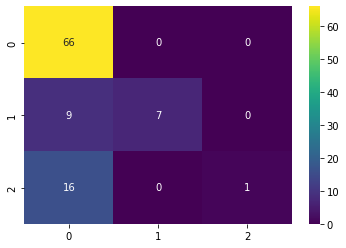

In [60]:
draw_confusion_matrix(asd,y_preds_arg)